In [1]:
from sklearn.preprocessing import KBinsDiscretizer
import numpy as np 
import time, math, random
from tqdm import trange
import matplotlib.pyplot as plt
from IPython.display import clear_output
import gym

### The Taxi Problem

from "Hierarchical Reinforcement Learning with the MAXQ Value Function Decomposition"
    by Tom Dietterich

Description:

    There are four designated locations in the grid world indicated by R(ed), G(reen), Y(ellow), and B(lue). When the episode starts, the taxi starts off at a random square and the passenger is at a random location. The taxi drives to the passenger's location, picks up the passenger, drives to the passenger's destination (another one of the four specified locations), and then drops off the passenger. Once the passenger is dropped off, the episode ends.

**Source**: https://github.com/openai/gym/blob/master/gym/envs/toy_text/taxi.py

**Observations:**

    There are 500 discrete states since there are 25 taxi positions, 5 possible locations of the passenger (including the case when the passenger is in the taxi), and 4 destination locations.
    Note that there are 400 states that can actually be reached during an episode. The missing states correspond to situations in which the passenger is at the same location as their destination, as this typically signals the end of an episode.
    
    Four additional states can be observed right after a successful episodes, when both the passenger and the taxi are at the destination.
    
    This gives a total of 404 reachable discrete states.

**Passenger locations:**

    - 0: R(ed)
    - 1: G(reen)
    - 2: Y(ellow)
    - 3: B(lue)
    - 4: in taxi
    
**destinations:**

    - 0: R(ed)
    - 1: G(reen)
    - 2: Y(ellow)
    - 3: B(lue)
    
**Actions:**

    There are 6 discrete deterministic actions:
    - 0: move south
    - 1: move north
    - 2: move east
    - 3: move west
    - 4: pickup passenger
    - 5: drop off passenger

**Rewards:**

    There is a default per-step reward of -1,
    except for delivering the passenger, which is +20,
    or executing "pickup" and "drop-off" actions illegally, which is -10.
    Rendering:
    - blue: passenger
    - magenta: destination
    - yellow: empty taxi
    - green: full taxi
    - other letters (R, G, Y and B): locations for passengers and destinations

**state space is represented by:**

        (taxi_row, taxi_col, passenger_location, destination)
    

In [2]:
# Show info
#?env.env

### Q-Learning

In [3]:
class Agent:

    def __init__(self, env, learning_rate=0.1, discount_factor=0.9):
        self.env = env
        
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        
        self.q_table = np.zeros([env.observation_space.n, env.action_space.n])
    
    def policy(self, state, epsilon):
        if np.random.rand() > epsilon:
            # Exploit
            action = np.argmax(self.q_table[state])
        else:
            # Explore
            action = np.random.randint(len(self.q_table[state]))
        return action
    
    def exploration_rate(self, episode, num_episodes):
        """# Define exploration rate change over time"""
        start_eps = 1.0
        end_eps = 0.1
        const_eps_episodes = 0.1 * num_episodes  # 10% of learning time
        eps_decay_episodes = 0.6 * num_episodes  # 60% of learning time

        if episode < const_eps_episodes:
            return start_eps
        elif episode < eps_decay_episodes:
            # Linear decay
            return start_eps - (episode - const_eps_episodes) / \
                               (eps_decay_episodes - const_eps_episodes) * (start_eps - end_eps)
        else:
            return end_eps

    def load_q_table(self, table_filename):
        table = np.load(table_filename)
        self.q_table = table
    
    def print_frames(self, frames):
        for i, frame in enumerate(frames):
            clear_output(wait=True)
            print(frame['frame'])
            print(f"Episode: {frame['episode']}")
            print(f"Timestep: {i + 1}")
            print(f"State: {frame['state']}")
            print(f"Action: {frame['action']}")
            print(f"Reward: {frame['reward']}")
            time.sleep(1)

    # train the agent for a given number of episodes
    # the agent trains using Q-Learning
    def train(self, training_episodes):
        # count the number of steps per episode
        # used to verify if the agent is learning
        steps_per_episode = np.zeros((training_episodes))
        run = 0
        for i in range(0, training_episodes):            
            state = self.env.reset()
            done = False
            num_steps = 0
            run+=1
            
            while not done:       
                num_steps += 1
                
                #epsilon = self.exploration_rate(i, training_episodes)
                #action = self.policy(state, epsilon)
                
                # select a greedy action from q-table
                action = np.argmax(self.q_table[state])
        
                next_state, reward, done, _ = self.env.step(action)
                
                q_value = self.q_table[state, action]
            
                max_q = np.max(self.q_table[next_state])

                new_q = q_value + self.learning_rate * (reward + self.discount_factor * max_q - q_value)
                self.q_table[state, action] = new_q

                state = next_state
            
            # total num of steps per episode
            steps_per_episode[i] = num_steps
        
        print("\nAvg num of steps per episode: " + str(np.mean(steps_per_episode)))
        plt.plot(steps_per_episode)
        plt.show()  

        outfile = open('q_table', 'wb')
        np.save(outfile, self.q_table)
        outfile.close()

    # test the agent for a given number of episodes
    # if render is active, it will print the steps and total reward
    def test(self, testing_episodes, render=False):
    
        MAX_ITERS = 100
        frames = []
        total_penalties = 0
        steps_per_episode = np.zeros((testing_episodes))
        for i in range(testing_episodes):
            
            state = self.env.reset()
            done = False
            total_reward = 0
            steps = []
            penalties, reward = 0, 0

            num_iters = 0
            
            while not done and num_iters < MAX_ITERS:
                action = np.argmax(self.q_table[state])
                steps.append(action)
                
                state, reward, done, _ = self.env.step(action)
                total_reward += reward

                num_iters += 1
                
                if reward == -10:
                    penalties += 1
        
                # Put each rendered frame into dict for animation
                frames.append({
                    'frame': self.env.render(mode='ansi'),
                    'episode': i, 
                    'state': state,
                    'action': action,
                    'reward': reward
                    }
                )
                # total num of steps per episode
                steps_per_episode[i] = num_iters
                total_penalties += penalties
        
        if render:
            self.print_frames(frames)
            
        print(f"\nResults after {testing_episodes} episodes:")
        print(f"Average timesteps per episode: {np.mean(steps_per_episode)}")
        print(f"Average penalties per episode: {total_penalties / testing_episodes}")


Avg num of steps per episode: 20.9457


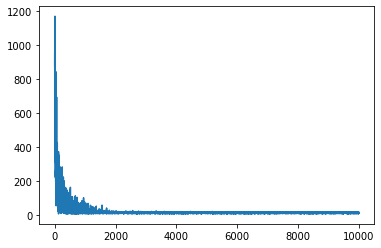

In [4]:
env = gym.make('Taxi-v3').env
agent = Agent(env)
training_episodes = 10000
agent.train(training_episodes)

In [6]:
testing_episodes = 10
agent.test(testing_episodes, render=True)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

Episode: 9
Timestep: 126
State: 410
Action: 5
Reward: 20
Results after 10 episodes:
Average timesteps per episode: 12.6
Average penalties per episode: 0.0
